<a href="https://colab.research.google.com/github/JMGilbert/STAT4241-Final-Project/blob/main/5241NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Don't forget to enable GPU:    
Edit > Notebook settings or Runtime>Change runtime type    
and select GPU as Hardware accelerator.

In [174]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tq
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import Data

In [2]:
#url of the dataset from our GitHub repository
url_red="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-red.csv"
url_white="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-white.csv"
red=pd.read_csv(url_red,sep=';')
white=pd.read_csv(url_white,sep=';')

<BarContainer object of 7 artists>

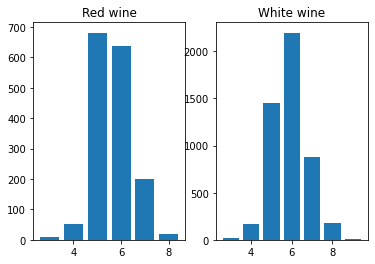

In [3]:
plt.subplot(1,2,1).set_title("Red wine")
plt.bar(list(set(red["quality"])),red["quality"].value_counts(sort=False).sort_index())
plt.subplot(1,2,2).set_title("White wine")
plt.bar(list(set(white["quality"])),white["quality"].value_counts(sort=False).sort_index())

In [4]:
print(white.isnull().values.any())
print(red.isnull().values.any())

False
False


In [5]:
X_white=white.loc[:, white.columns != 'quality']
Y_white=white.loc[:, white.columns == 'quality']
X_red=red.loc[:, red.columns != 'quality']
Y_red=red.loc[:, red.columns == 'quality']

In [6]:
def TO_TORCH(m):
    #convert an array/DF into a tensor with gpu on if necessary
    if isinstance(m, np.ndarray):
        m=torch.from_numpy(m).float()
    elif isinstance(m, pd.DataFrame):
        m=torch.from_numpy(m.values).float()
    if train_on_gpu:
        m = m.to(device="cuda")
    return(m)

In [203]:
red_class=pd.unique(red['quality'])
white_class=pd.unique(white['quality'])
red_class.sort()
white_class.sort()

In [85]:
predictors_name=list(red.columns)[:-1]
predictors_name

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# $\frac{2}{3}$/$\frac{1}{3}$ Holdout Split and Standardization

In [186]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(X_white, Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(X_red, Y_red, test_size=0.33, random_state=42)

TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)

# Nerual Networks

## Architecture

In [8]:
# Neural Network structure
class Net(nn.Module):
    def __init__(self,INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM,DROP_PR=0.0,BN=False):
        super(Net, self).__init__()
        self.input_dim = INPUT_DIM
        self.output_dim = OUTPUT_DIM
        self.hidden_dim = HIDDEN_DIM
        self.DROP_PR = DROP_PR
        current_dim = self.input_dim
        self.layers = nn.ModuleList()
        self.BN=BN
        self.bn = nn.ModuleList()
        for hdim in self.hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            self.bn.append(nn.BatchNorm1d(hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, self.output_dim))
        self.dropout = nn.Dropout(self.DROP_PR)

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.BN:
                x = self.bn[i](x)
            x = torch.sigmoid(x)
            x = self.dropout(x)
        out = self.layers[-1](x)
        return out 

#Loss function: mean absolute deviation
criterion = torch.nn.L1Loss() 

#Accuracy with tolerance
def ACCURACY(Y_pred,target,Tolerance):
    v=(abs(Y_pred-target)<=Tolerance)*1.0
    return(torch.mean(v))

#Kappa statistic compared with a random classifier
def KAPPA(Y_pred,target):
    #only work for Tolerance=0.5
    KAPP=cohen_kappa_score(target.cpu().detach().numpy(),torch.round(Y_pred).cpu().detach().numpy())
    #KAPP2=cohen_kappa_score(torch.round(Y_pred).cpu().detach().numpy(),target.cpu().detach().numpy())    
    return(KAPP)

## Toy example (Ignore this part)
red wine

In [9]:
T=1 #Tolerance:0.25,0.5,1.0

LR=1e-2
OPT="SGD" # "SGD" or "ADAM"
EPOCH=30000

HIDDEN_DIM = [11]
INPUT_DIM = X_TRAIN_white.shape[1]
OUTPUT_DIM = 1
TOY_MODEL=Net(INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM)
if train_on_gpu:
    TOY_MODEL.cuda()
#Optimizer: 
if OPT=="SGD":
    optimizer = torch.optim.SGD(TOY_MODEL.parameters(),lr=LR)
if OPT=="ADAM":
    optimizer = torch.optim.Adam(TOY_MODEL.parameters(),lr=LR, betas=(0.9, 0.99))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=DECAY)

In [10]:
LOSS_ARR=[]
torch.manual_seed(0)
for epoch in tq(range(EPOCH)):
    optimizer.zero_grad()
    outputs=TOY_MODEL(X_TRAIN_red) #prediction
    loss = criterion(outputs, Y_TRAIN_red) #compared with the true labels
    LOSS_ARR.append(loss.data)
    loss.backward()
    optimizer.step()    
    if (epoch+1)%round(EPOCH/5)==0:
        kappa=KAPPA(outputs, Y_TRAIN_red)
        accuracy=ACCURACY(outputs,Y_TRAIN_red,T).item()
        print("\n After {} Epochs: MAD is {}; Accuracy is {}% (T={}); KAPPA is {}% (T=0.5)".format((epoch+1),round(loss.item(),3),round(accuracy*100,3),T,round(kappa*100,3)))


 20%|██        | 6106/30000 [00:05<00:24, 986.49it/s]


 After 6000 Epochs: MAD is 0.48; Accuracy is 89.262% (T=1); KAPPA is 33.62% (T=0.5)


 41%|████      | 12166/30000 [00:11<00:15, 1152.80it/s]


 After 12000 Epochs: MAD is 0.473; Accuracy is 89.449% (T=1); KAPPA is 34.568% (T=0.5)


 61%|██████    | 18193/30000 [00:16<00:10, 1121.02it/s]


 After 18000 Epochs: MAD is 0.465; Accuracy is 89.449% (T=1); KAPPA is 35.268% (T=0.5)


 80%|████████  | 24131/30000 [00:22<00:05, 1119.51it/s]


 After 24000 Epochs: MAD is 0.457; Accuracy is 89.636% (T=1); KAPPA is 36.783% (T=0.5)


100%|██████████| 30000/30000 [00:27<00:00, 1099.56it/s]


 After 30000 Epochs: MAD is 0.452; Accuracy is 90.103% (T=1); KAPPA is 39.45% (T=0.5)


Text(0.5, 1.0, 'Final Loss = 0.4520167112350464')

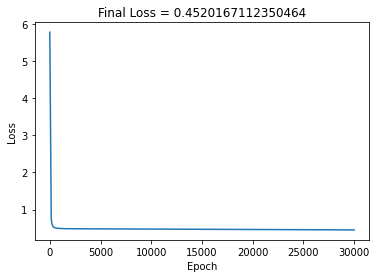

In [11]:
zoom=np.floor(len(LOSS_ARR)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_ARR)-zoom)+zoom, LOSS_ARR[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_ARR[-1]))

In [12]:
test_pred=TOY_MODEL(X_TEST_red)
loss = criterion(test_pred, Y_TEST_red)
print("Test MAD is {};".format(round(loss.item(),3)))
for T in [0.25,0.5,1.0]: 
    accuracy=ACCURACY(test_pred,Y_TEST_red,T).item()
    print("Test Accuracy is {}% (T={});".format(round(accuracy*100,3),T))
test_kappa=KAPPA(test_pred, Y_TEST_red)
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.498;
Test Accuracy is 33.712% (T=0.25);
Test Accuracy is 57.197% (T=0.5);
Test Accuracy is 89.962% (T=1.0);
Test KAPPA is 29.517% (T=0.5);


## Wrap it up

In [13]:
def TRAIN_NN(TRAIN_X,TRAIN_Y,HIDDEN_DIM,EPOCH,DROP_PR=0.0,BN=False,LR=1e-2,OPT="SGD",T=0.5):
    #TRAIN_X,TRIAN_Y: should be tensors
    # HIDDEN_DIM: [H] or deeper
    # BN: Bool, if using Batch Normalization or not
    # "SGD" or "ADAM"
    # T:0.25,0.5,1.0
    INPUT_DIM = TRAIN_X.shape[1]
    OUTPUT_DIM = 1
    MODEL=Net(INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM)
    if train_on_gpu:
        MODEL.cuda()
    #Optimizer: 
    if OPT=="SGD":
        optimizer = torch.optim.SGD(MODEL.parameters(),lr=LR)
    if OPT=="ADAM":
        optimizer = torch.optim.Adam(MODEL.parameters(),lr=LR, betas=(0.9, 0.99))
    LOSS_ARR=[]
    torch.manual_seed(0)
    for epoch in tq(range(EPOCH)):
        optimizer.zero_grad()
        outputs=MODEL(TRAIN_X) #prediction
        loss = criterion(outputs, TRAIN_Y) #compared with the true labels
        LOSS_ARR.append(loss.data)
        loss.backward()
        optimizer.step()    
        if (epoch+1)%round(EPOCH/5)==0:
            kappa=KAPPA(outputs, TRAIN_Y)
            accuracy=ACCURACY(outputs,TRAIN_Y,T).item()
            print("\n After {} Epochs: MAD is {}; Accuracy is {}% (T={}); KAPPA is {}% (T=0.5)".format((epoch+1),round(loss.item(),3),round(accuracy*100,3),T,round(kappa*100,3)))
    return({"MODEL":MODEL,"LOSS_ARR":LOSS_ARR})

In [14]:
def TEST_NN(MODEL,TEST_X,TEST_Y,T_list=[0.25,0.5,1]):
    MODEL.eval()
    test_pred=MODEL(TEST_X)
    loss = criterion(test_pred, TEST_Y)
    MAD=loss.item()
    accuracy_list=[ACCURACY(test_pred,TEST_Y,T).item() for T in T_list]
    kappa=KAPPA(test_pred, TEST_Y)
    MODEL.train()
    return({"MAD":MAD,"accuracy_list":accuracy_list,"kappa":kappa})

### White wine

In [15]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,[11],EPOCH=30000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_ARR"]

 21%|██        | 6166/30000 [00:05<00:19, 1191.97it/s]


 After 6000 Epochs: MAD is 0.578; Accuracy is 53.033% (T=0.5); KAPPA is 24.066% (T=0.5)


 40%|████      | 12139/30000 [00:10<00:14, 1200.40it/s]


 After 12000 Epochs: MAD is 0.574; Accuracy is 53.49% (T=0.5); KAPPA is 24.962% (T=0.5)


 61%|██████    | 18225/30000 [00:15<00:10, 1168.26it/s]


 After 18000 Epochs: MAD is 0.568; Accuracy is 53.49% (T=0.5); KAPPA is 25.102% (T=0.5)


 80%|████████  | 24119/30000 [00:21<00:05, 1055.41it/s]


 After 24000 Epochs: MAD is 0.56; Accuracy is 54.282% (T=0.5); KAPPA is 26.575% (T=0.5)


100%|██████████| 30000/30000 [00:26<00:00, 1129.81it/s]


 After 30000 Epochs: MAD is 0.554; Accuracy is 54.16% (T=0.5); KAPPA is 26.707% (T=0.5)


Text(0.5, 1.0, 'Final Loss = 0.5540364980697632')

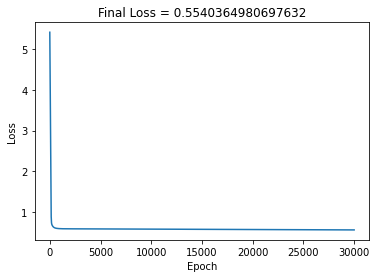

In [16]:
zoom=np.floor(len(LOSS_white)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_white[-1]))

In [17]:
T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test MAD is {};".format(round(Result_TEST_white["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.569;
Test Accuracy is 28.262% (T=0.25);
Test Accuracy is 52.999% (T=0.5);
Test Accuracy is 84.045% (T=1);
Test KAPPA is 24.773% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

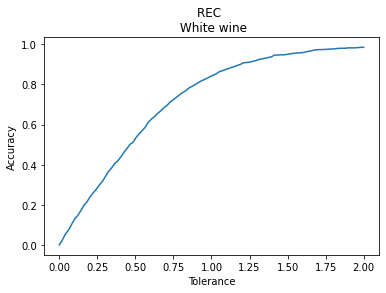

In [18]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

### Red wine

In [19]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,[11],EPOCH=30000)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_ARR"]

 21%|██        | 6222/30000 [00:05<00:21, 1101.53it/s]


 After 6000 Epochs: MAD is 0.477; Accuracy is 60.878% (T=0.5); KAPPA is 34.755% (T=0.5)


 41%|████      | 12212/30000 [00:10<00:15, 1164.57it/s]


 After 12000 Epochs: MAD is 0.468; Accuracy is 61.625% (T=0.5); KAPPA is 35.881% (T=0.5)


 61%|██████    | 18160/30000 [00:16<00:11, 1063.34it/s]


 After 18000 Epochs: MAD is 0.46; Accuracy is 62.278% (T=0.5); KAPPA is 37.073% (T=0.5)


 81%|████████  | 24239/30000 [00:21<00:04, 1181.94it/s]


 After 24000 Epochs: MAD is 0.455; Accuracy is 62.932% (T=0.5); KAPPA is 38.462% (T=0.5)


100%|██████████| 30000/30000 [00:26<00:00, 1122.31it/s]


 After 30000 Epochs: MAD is 0.451; Accuracy is 63.119% (T=0.5); KAPPA is 38.728% (T=0.5)


Text(0.5, 1.0, 'Final Loss = 0.4507947266101837')

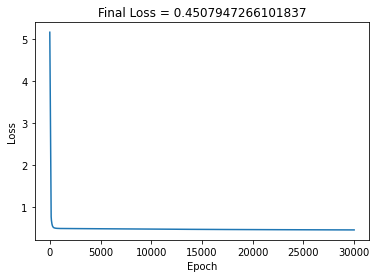

In [20]:
zoom=np.floor(len(LOSS_red)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_red)-zoom)+zoom, LOSS_red[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_red[-1]))

In [21]:
T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test MAD is {};".format(round(Result_TEST_red["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.496;
Test Accuracy is 36.364% (T=0.25);
Test Accuracy is 57.386% (T=0.5);
Test Accuracy is 88.826% (T=1);
Test KAPPA is 30.16% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

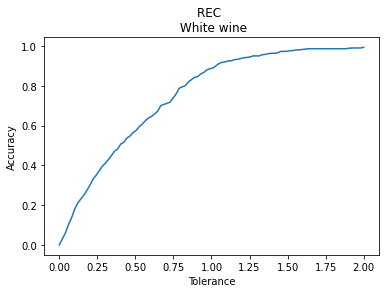

In [22]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

#  Sensitivity Analysis 
!“correlation does not equal causation.”

In [28]:
p=X_TRAIN_red.shape[1] #11

In [161]:
def Sensitivity_Analysis(MODEL,a,L=6):
    #a: indicator of the predictor, a=0,1,2,...10(p-1)
    MODEL.eval()
    Analysis_X=torch.zeros((L,p))
    Analysis_X[:,(a)]=torch.from_numpy(np.linspace(-1, 1, 6, endpoint=True))
    if train_on_gpu:
        Analysis_X=Analysis_X.to(device="cuda")
    result=MODEL(Analysis_X).var()
    MODEL.train()
    return result.cpu().detach().numpy()

In [162]:
V_red=np.zeros(p)
for a in range(p):
  V_red[a]=(Sensitivity_Analysis(MODEL_NN_red,a))
R_red=V_red/V_red.sum()*100
#R_red=pd.DataFrame(R_red,index=predictors_name)

V_white=np.zeros(p)
for a in range(p):
  V_white[a]=(Sensitivity_Analysis(MODEL_NN_white,a))
R_white=V_white/V_white.sum()*100
#R_white=pd.DataFrame(R_white,index=predictors_name)
R=pd.DataFrame({"red":R_red,"white":R_white}, index=predictors_name)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7c5a0c7d0>],
      dtype=object)

<Figure size 720x720 with 0 Axes>

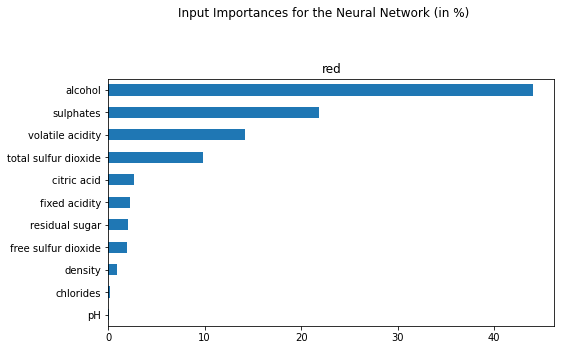

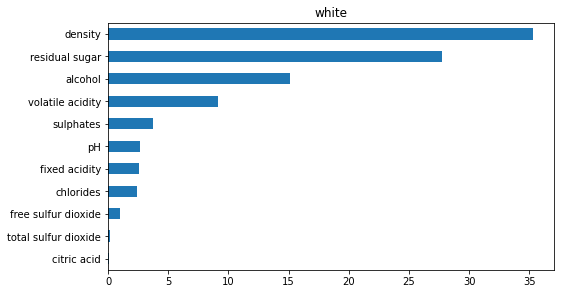

In [163]:
plt.figure(figsize=(10,10))
R.sort_values(by="red").plot.barh(y='red',legend=None,subplots=True, layout=(2,1),figsize=(8,10),title="Input Importances for the Neural Network (in %)")
R.sort_values(by="white").plot.barh(y='white',legend=None,subplots=True, layout=(2,1),figsize=(8,10))


# (Maybe don't have time?) Model Selection

# the Problem of Imbalance Data

In [263]:
for i,c in enumerate(red_class):
    print("there are {} red wine samples with the score of {}".format(len(Y_red_torch[Y_red_torch==red_class[i]]),c))
print("\n")
for i,c in enumerate(white_class):
    print("there are {} white wine samples with the score of {}".format(len(Y_white_torch[Y_white_torch==white_class[i]]),c))
   

there are 10 red wine samples with the score of 3
there are 53 red wine samples with the score of 4
there are 681 red wine samples with the score of 5
there are 638 red wine samples with the score of 6
there are 199 red wine samples with the score of 7
there are 18 red wine samples with the score of 8


there are 20 white wine samples with the score of 3
there are 163 white wine samples with the score of 4
there are 1457 white wine samples with the score of 5
there are 2198 white wine samples with the score of 6
there are 880 white wine samples with the score of 7
there are 175 white wine samples with the score of 8
there are 5 white wine samples with the score of 9


## Confusion Matrix T=0.5
Using the full data

>??? suppose T=0.5, and the predicted value is 2.5, which column of confusion matrix should we add it to, 2 or 3??

In [241]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())   
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion 

,3,4,5,6,7,8
3,0,0,9,1,0,0
4,0,0,41,12,0,0
5,0,0,537,142,2,0
6,0,0,219,384,35,0
7,0,0,8,135,56,0
8,0,0,0,10,8,0


In [208]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())   
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion 

,3,4,5,6,7,8,9
3,0,1,7,11,0,1,0
4,0,5,102,54,2,0,0
5,0,7,759,670,21,0,0
6,0,3,379,1589,227,0,0
7,0,0,28,576,276,0,0
8,0,0,2,103,70,0,0
9,0,0,0,1,4,0,0


using the test data

In [209]:
red_pred=np.round(MODEL_NN_red(X_TEST_red).cpu().detach().numpy())   
red_confusion=confusion_matrix(Y_TEST_red.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion  

,3,4,5,6,7,8
3,0,0,2,0,0,0
4,0,0,13,6,0,0
5,0,0,168,48,1,0
6,0,0,84,118,11,0
7,0,0,3,50,17,0
8,0,0,0,2,5,0


In [213]:
white_pred=np.round(MODEL_NN_white(X_TEST_white).cpu().detach().numpy())   
white_confusion=confusion_matrix(Y_TEST_white.cpu().detach().numpy(), white_pred)
#white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion=pd.DataFrame(white_confusion,index=red_class,columns=red_class) 
white_confusion 

,3,4,5,6,7,8
3,0,0,3,3,0,1
4,0,2,25,19,0,0
5,0,2,250,210,10,0
6,0,0,139,513,79,0
7,0,0,10,202,92,0
8,0,0,1,34,22,0


None of the 9-point wine in the test dataset!   
In the test dataset, one of the 3-point wine is classified as 8!

## Precision for the different classes

using the full data

In [255]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    output=MODEL_NN_red(X_red_torch)[Y_red_torch==red_class[i]]
    pre1=100*ACCURACY(output,label,0.5).cpu().detach().numpy()
    pre2=100*ACCURACY(output,label,1).cpu().detach().numpy()
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2
red_precision

,T=0.5 (%),T=1.0 (%)
3,0,0
4,0,32.0755
5,78.8546,95.301
6,60.1881,96.8652
7,28.1407,75.3769
8,0,0


In [256]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    output=MODEL_NN_white(X_white_torch)[Y_white_torch==white_class[i]]
    pre1=100*ACCURACY(output,label,0.5).cpu().detach().numpy()
    pre2=100*ACCURACY(output,label,1).cpu().detach().numpy()
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2
white_precision

,T=0.5 (%),T=1.0 (%)
3,0,0
4,3.06748,30.0613
5,52.0933,88.8813
6,72.293,97.0883
7,31.3636,74.7727
8,0,6.28571
9,0,0


# To be Continued... To fix the Problem of Imbalance data